In [23]:
import os
import string
from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline

import nltk
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec

from tensorflow.config.experimental import list_physical_devices, set_memory_growth
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Embedding, Dropout, SpatialDropout1D, SimpleRNN
from tensorflow.keras.regularizers import l2

import optuna

from cybnews.data import get_data, welf_join_text

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

print("Num GPUs Available: ", len(list_physical_devices('GPU')))

gpus = list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1


In [24]:
df = pd.read_csv('/home/tober/devel/lewagon/project/cyb-news/data/unified_data.csv')

# print(df.shape)
# df.drop_duplicates(inplace=True)
# print(df.shape)
# df.dropna(inplace=True)
# print(df.shape)
#df.to_csv(file_name)

In [25]:
df.head()

df.all_text_cleaned.describe()

count                                                154820
unique                                               154820
top       culture war history conversation andrew hartma...
freq                                                      1
Name: all_text_cleaned, dtype: object

In [26]:
def clean(sentence):
    sentence = ''.join(char for char in sentence if not char.isdigit())
    sentence = sentence.strip()
    sentence = sentence.lower()
    
    for x in string.punctuation:
        sentence = sentence.replace(x, '')

    for x in ['’', '“', '”', '-', '"' ]:
        sentence = sentence.replace(x, '')
    return sentence
        

df["all_text_cleaned"] = df["all_text_cleaned"].apply(clean)


In [27]:
df.rename(columns={'all_text_cleaned': 'all_text'}, inplace=True)

Text Length Distribution Summary:
count    154820.000000
mean       2409.595569
std        2734.166453
min           1.000000
25%         886.000000
50%        1777.000000
75%        3075.000000
max      138332.000000
Name: text_length, dtype: float64


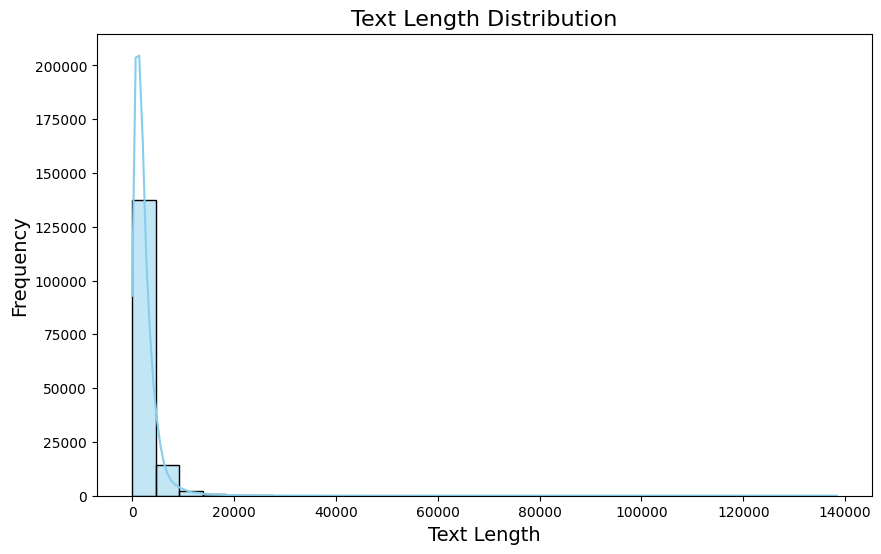

In [28]:
df['text_length'] = df['all_text'].str.len()

# Step 2: Describe the distribution
length_description = df['text_length'].describe()

print("Text Length Distribution Summary:")
print(length_description)

# Step 3: Visualize the distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=30, kde=True, color='skyblue')
plt.title('Text Length Distribution', fontsize=16)
plt.xlabel('Text Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

Q1 (25th percentile): 886.0
Q3 (75th percentile): 3075.0
IQR (Interquartile Range): 2189.0
Lower Bound for Outliers: 0
Upper Bound for Outliers: 6358.5


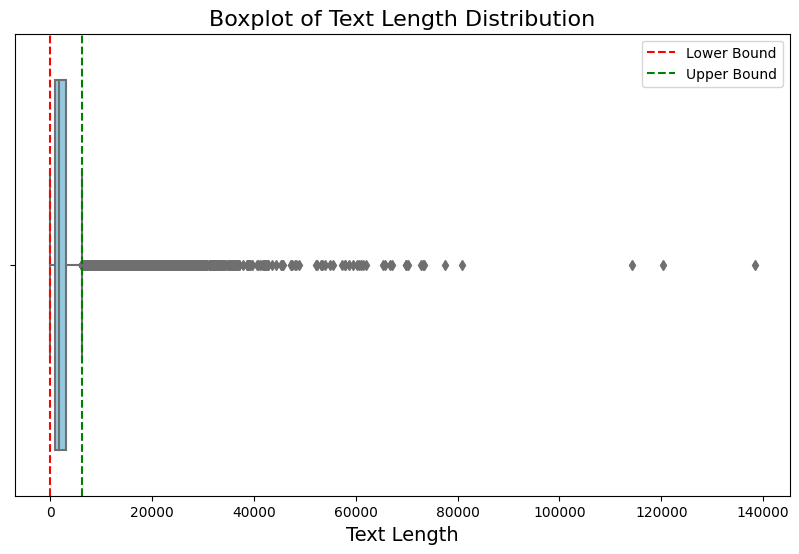

In [29]:
Q1 = df['text_length'].quantile(0.25)
Q3 = df['text_length'].quantile(0.75)

# Step 3: Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Step 4: Calculate the outlier borders
lower_bound = Q1 - 1.5 * IQR
if lower_bound < 0:
    lower_bound = 0
upper_bound = Q3 + 1.5 * IQR

print(f"Q1 (25th percentile): {Q1}")
print(f"Q3 (75th percentile): {Q3}")
print(f"IQR (Interquartile Range): {IQR}")
print(f"Lower Bound for Outliers: {lower_bound}")
print(f"Upper Bound for Outliers: {upper_bound}")

# Step 5: Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['text_length'], color='skyblue')
plt.title('Boxplot of Text Length Distribution', fontsize=16)
plt.xlabel('Text Length', fontsize=14)
plt.axvline(x=lower_bound, color='red', linestyle='--', label='Lower Bound')
plt.axvline(x=upper_bound, color='green', linestyle='--', label='Upper Bound')
plt.legend()
plt.show()

In [30]:

# exactly 95% are within the size of 6380
max_seq_length = 6380

below_count = (df['text_length'] < max_seq_length).sum()
total_count = len(df)
percentage_below = (below_count / total_count) * 100

print(f"Percentage of text entries below {max_seq_length} characters: {percentage_below:.2f}%")

Percentage of text entries below 6380 characters: 95.00%


In [31]:
X = df.all_text
y = df.label

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42
)

KeyboardInterrupt: 

In [ ]:
X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_tokenized, maxlen=max_seq_length, dtype='float32', padding='pre', value=0)
X_test_padded = pad_sequences(X_test_tokenized, maxlen=max_seq_length, dtype='float32', padding='pre', value=0)

flud nice social news reader window phone flud nice social news reader window phone headline bitcoin blockchain search exceed trump blockchain stock next flud look like metroey news reader app window phone take spin soon check press release introduce new kind social news reader flud place everyone news personality first time ever thing read give topical credibility among friend follower beautiful design simple user interface integrate social feature make flud best place read news customize flud personal taste follow favorite blog news sit save story read time offline flud article love connect friend fluders share interest flud profile allow discover news personality become credible source information
[85982, 1893, 326, 50, 392, 1493, 745, 85982, 1893, 326, 50, 392, 1493, 745, 145, 154, 52, 123, 167, 4, 52, 105, 53, 85982, 72, 20, 309630, 50, 392, 2322, 1493, 745, 18, 2844, 765, 641, 301, 221, 1430, 13, 421, 326, 50, 392, 85982, 143, 601, 50, 3130, 33, 12, 371, 71, 169, 48, 12085, 3252,

In [ ]:
print(f'original  :{X_train.iloc[0]}')
print(f'tokenized :{X_train_tokenized[0]}')
print(f'padded    :{X_train_padded[0]}')

original  :flud nice social news reader window phone flud nice social news reader window phone headline bitcoin blockchain search exceed trump blockchain stock next flud look like metroey news reader app window phone take spin soon check press release introduce new kind social news reader flud place everyone news personality first time ever thing read give topical credibility among friend follower beautiful design simple user interface integrate social feature make flud best place read news customize flud personal taste follow favorite blog news sit save story read time offline flud article love connect friend fluders share interest flud profile allow discover news personality become credible source information
tokenized :[85982, 1893, 326, 50, 392, 1493, 745, 85982, 1893, 326, 50, 392, 1493, 745, 145, 154, 52, 123, 167, 4, 52, 105, 53, 85982, 72, 20, 309630, 50, 392, 2322, 1493, 745, 18, 2844, 765, 641, 301, 221, 1430, 13, 421, 326, 50, 392, 85982, 143, 601, 50, 3130, 33, 12, 371, 71,

In [ ]:
vocab_size = len(tokenizer.index_word) + 1  # also num of features
print(f'vocab_size: {vocab_size}')

In [ ]:
vector_size = 400
window_size = 4

word_sentences = [word_tokenize(sentence) for sentence in X]
word2vec_model = Word2Vec(sentences=word_sentences, vector_size=vector_size, window=window_size, min_count=1, workers=4)

embedding_matrix = np.zeros((vocab_size, word2vec_model.vector_size))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]